## In this project, we use and  evaluate the insurance cost data with several different models and a neural network.

In [1]:
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import Ridge

## Data Preprocessing

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
le_encoder = LabelEncoder()
data['sex'] = le_encoder.fit_transform(data['sex'])
data['smoker'] = le_encoder.fit_transform(data['smoker'])
data['region'] = le_encoder.fit_transform(data['region'])

In [5]:
data.duplicated().sum()

1

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data['bmi'] = data['bmi'].astype('int64')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   int64  
 2   bmi       1337 non-null   int64  
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   int64  
 5   region    1337 non-null   int64  
 6   charges   1337 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 83.6 KB


## EDA(Exploratory Data Analysis)

                                             |          | [  0%]   00:00 -> (? left)


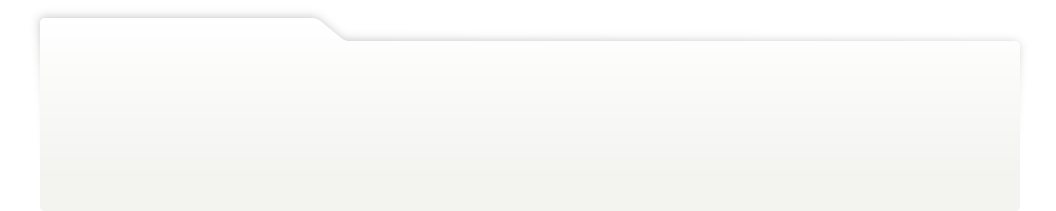
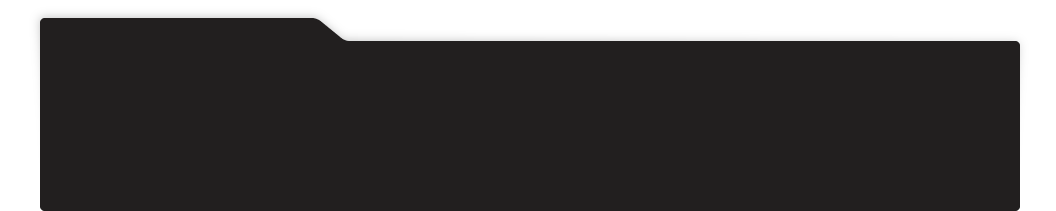
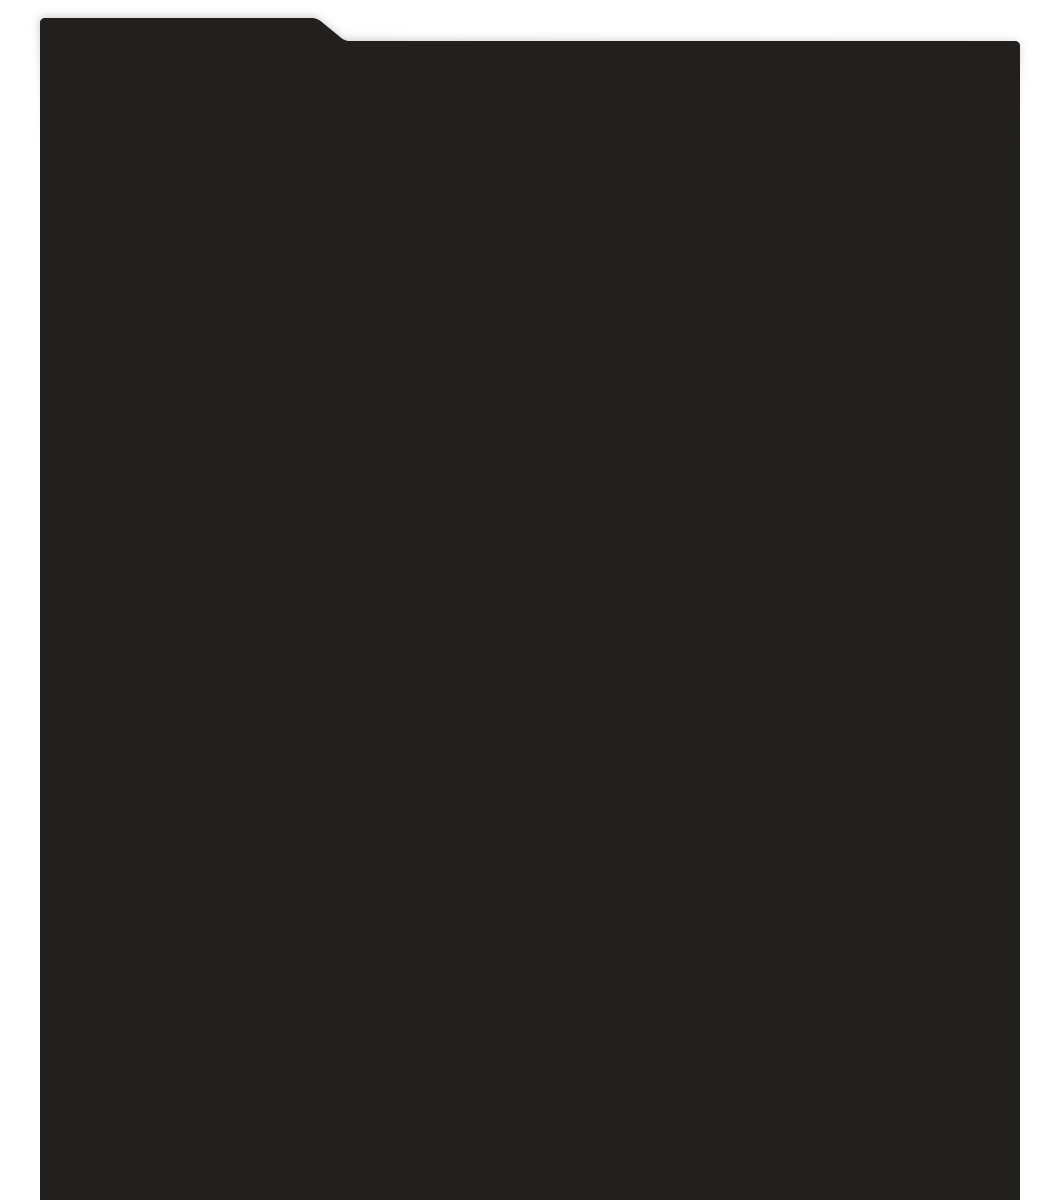
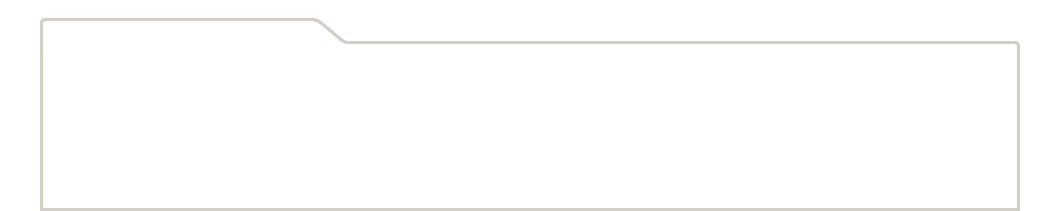
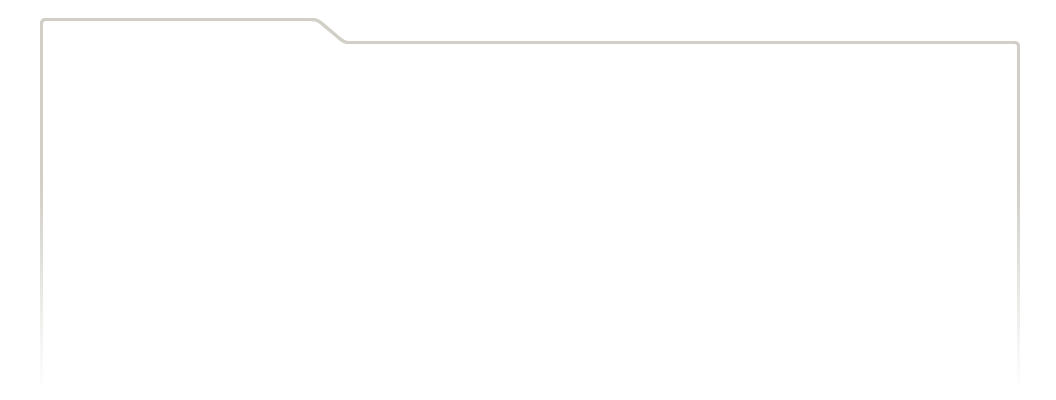
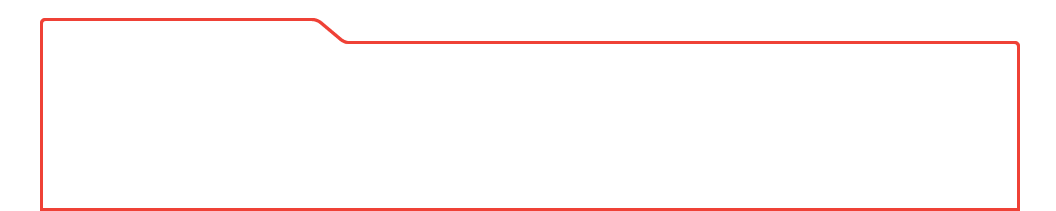
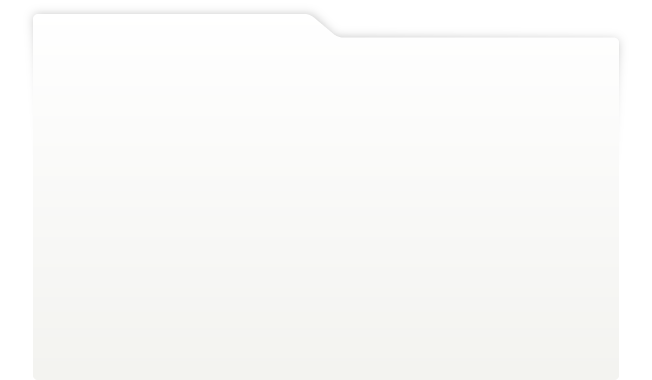
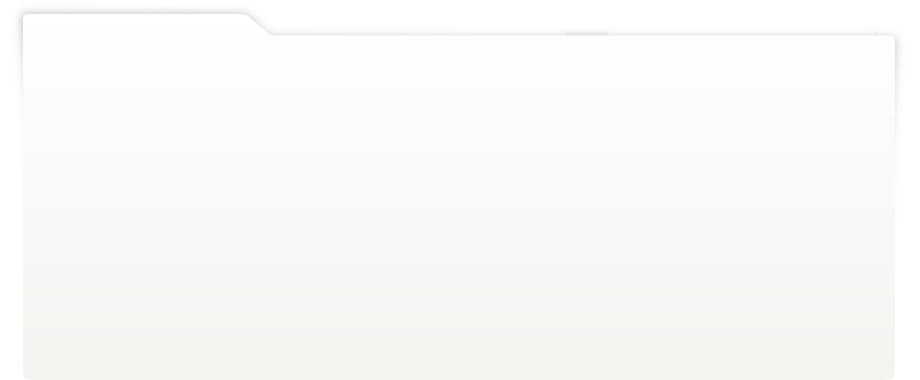
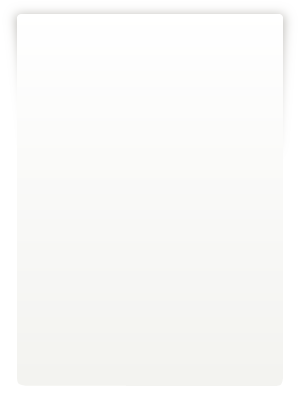
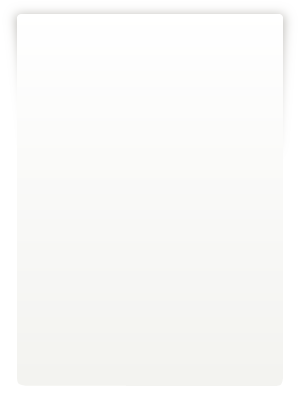
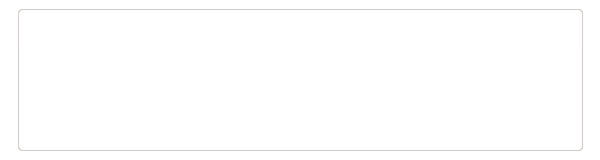
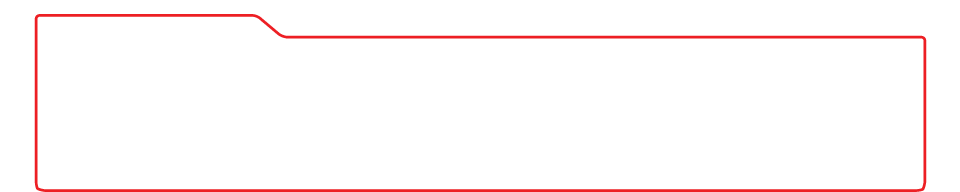
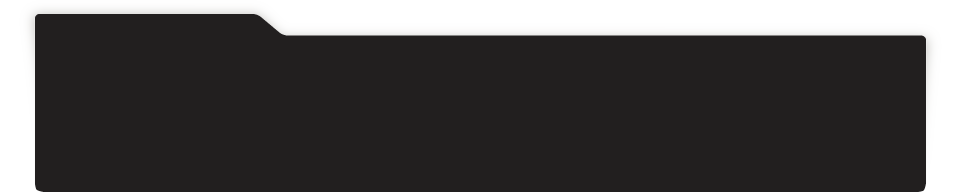
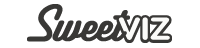
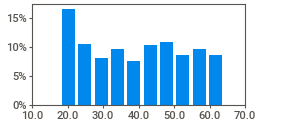
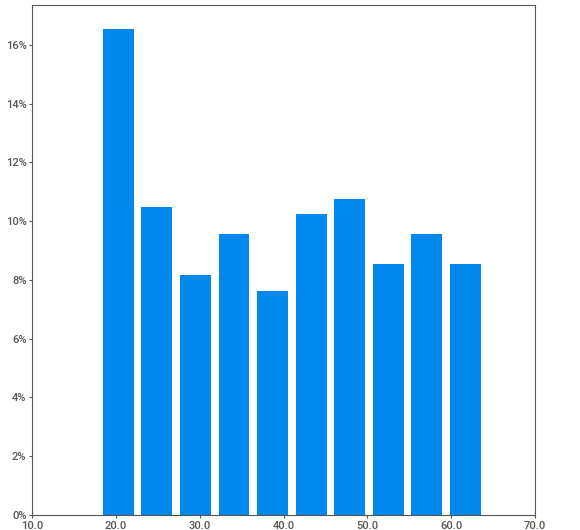
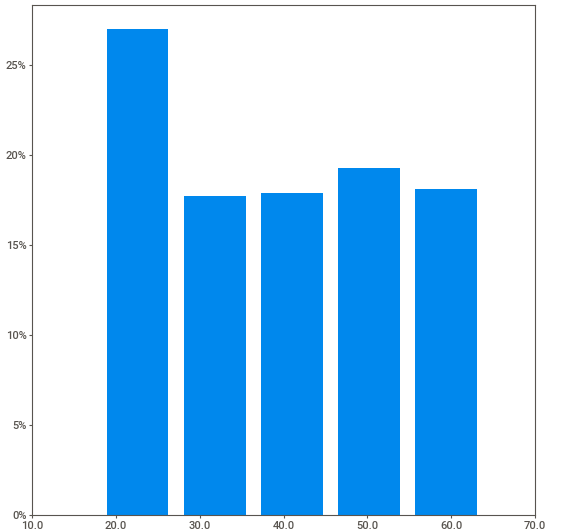
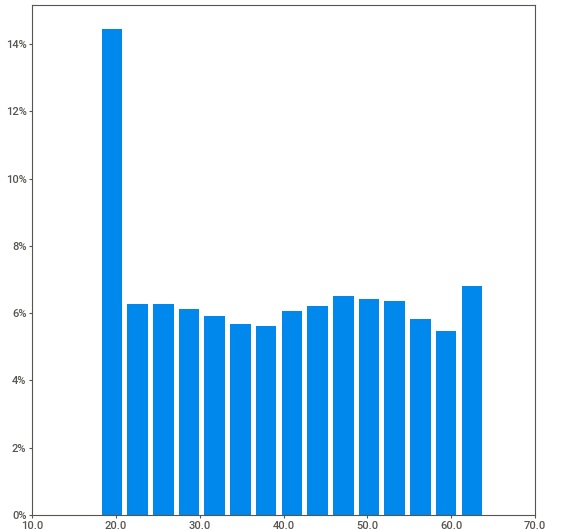
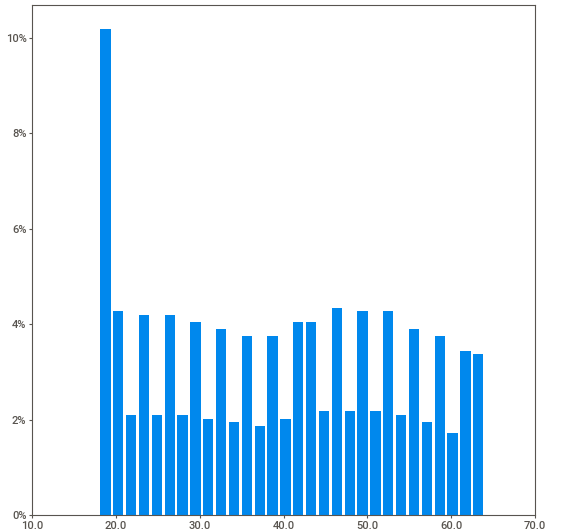
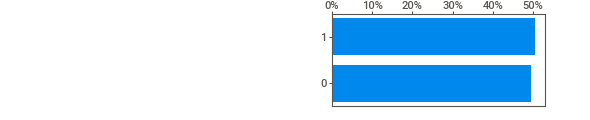
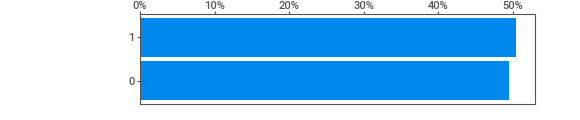
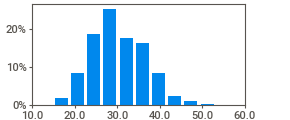
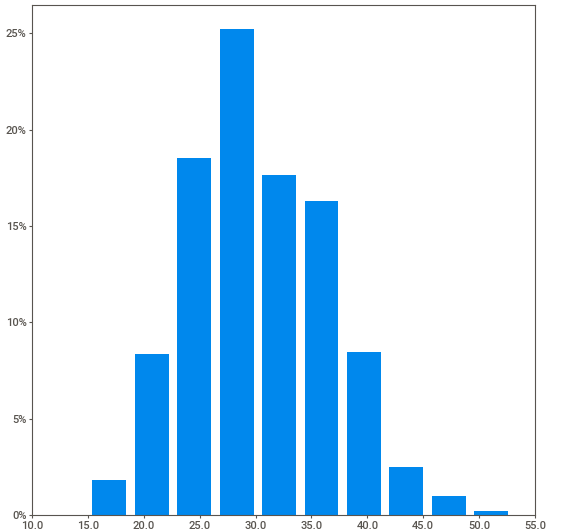
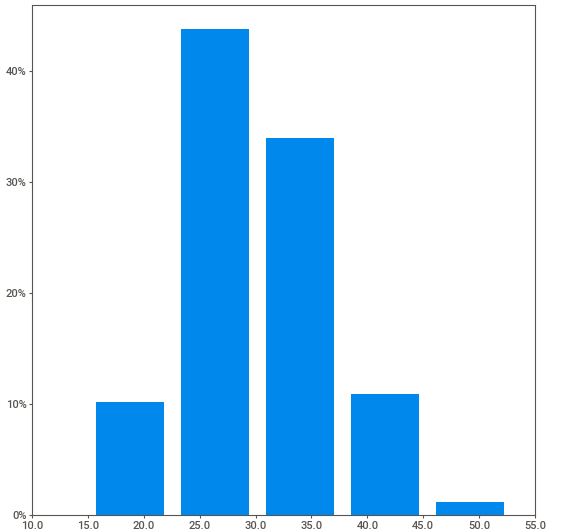
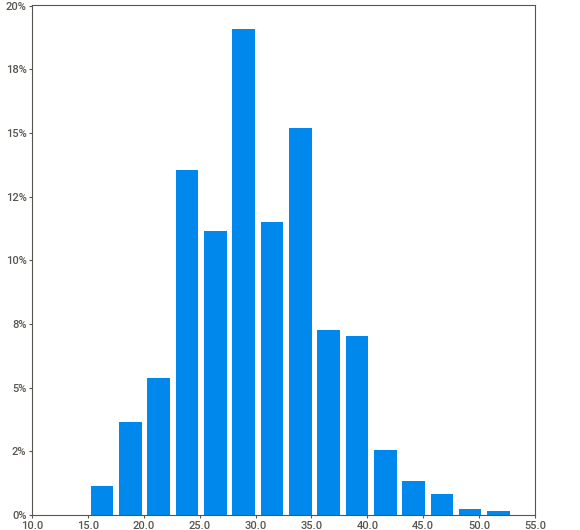
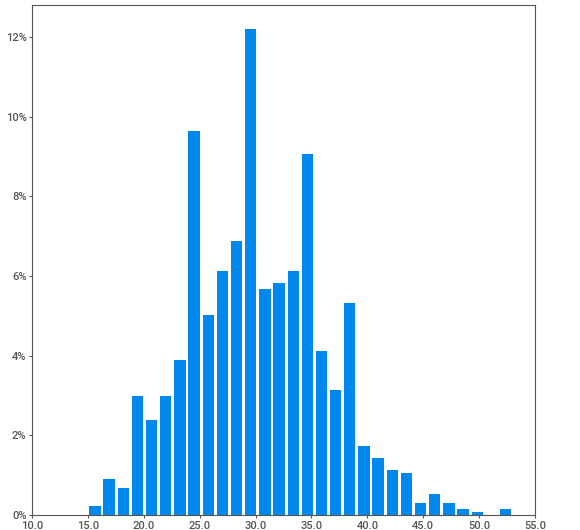
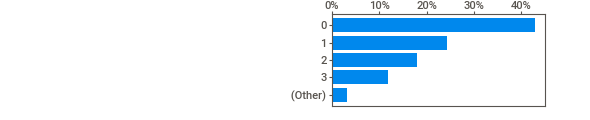
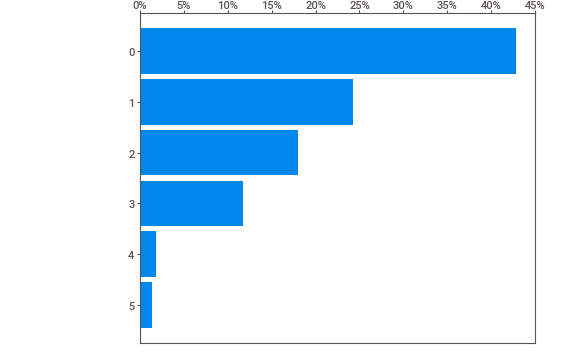
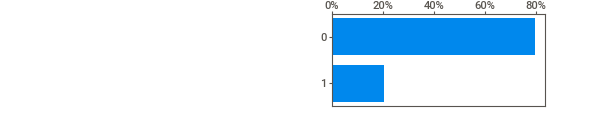
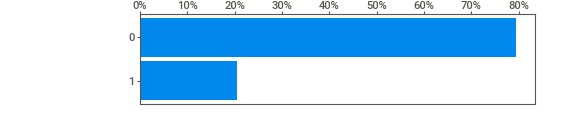
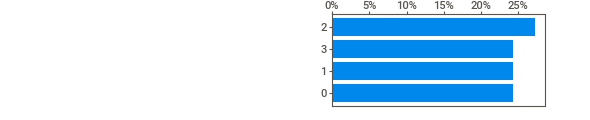
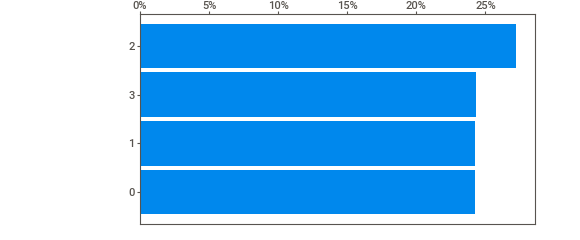
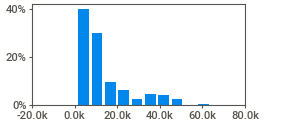
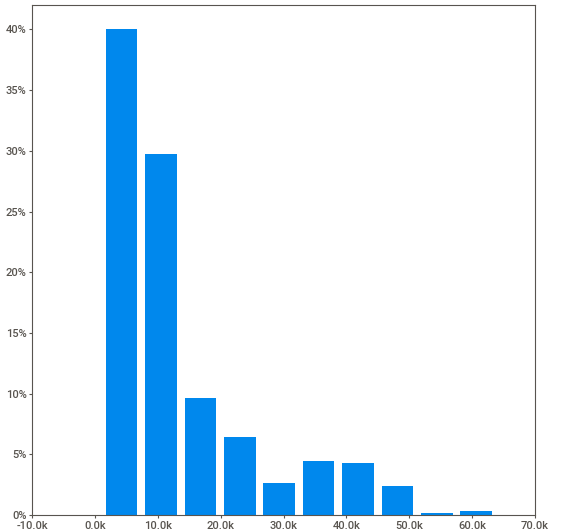
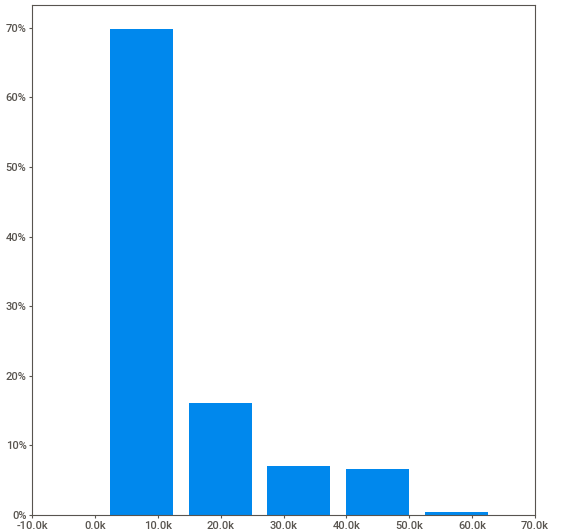
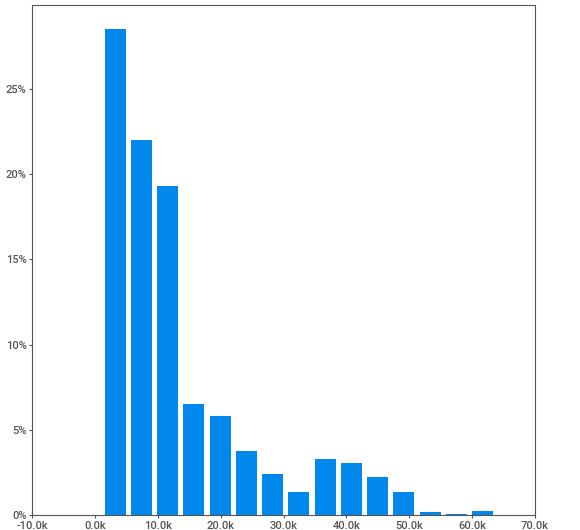
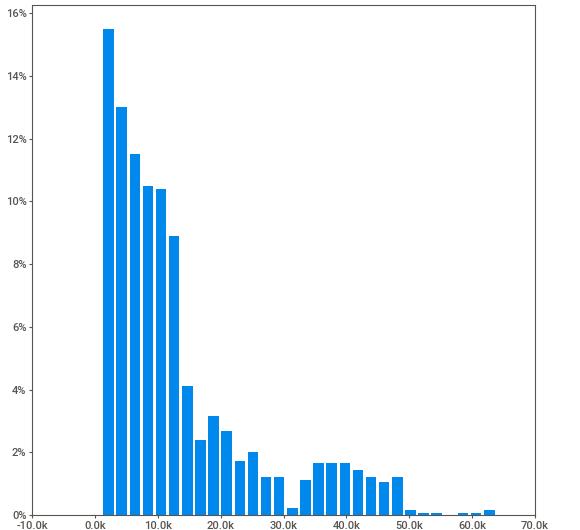
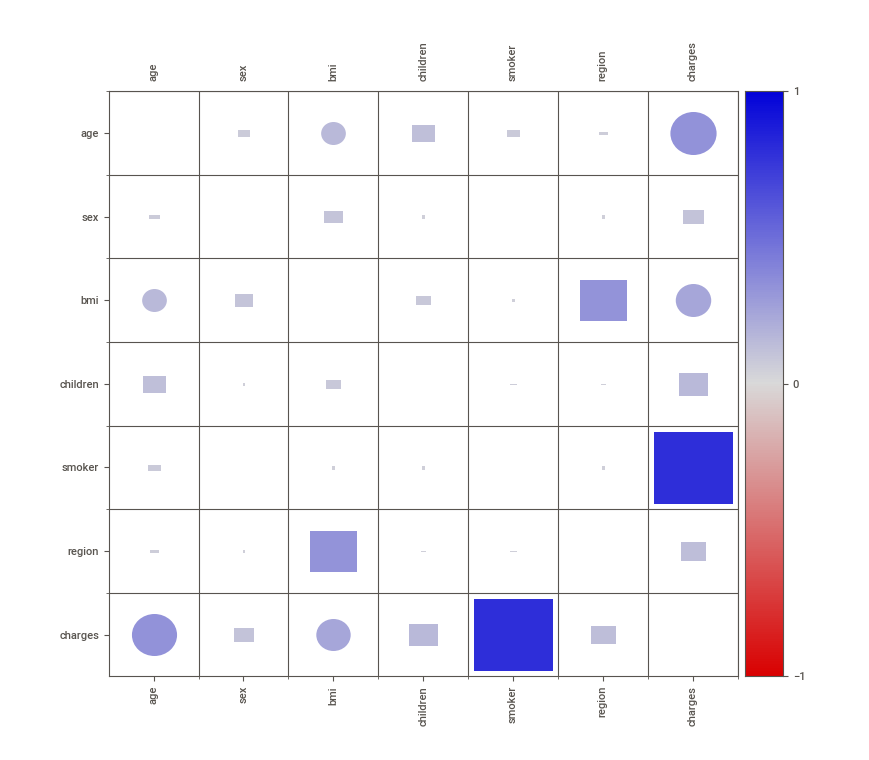
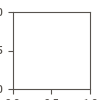

In [9]:
data_report = sv.analyze(data)
data_report.show_notebook()

<Axes: >

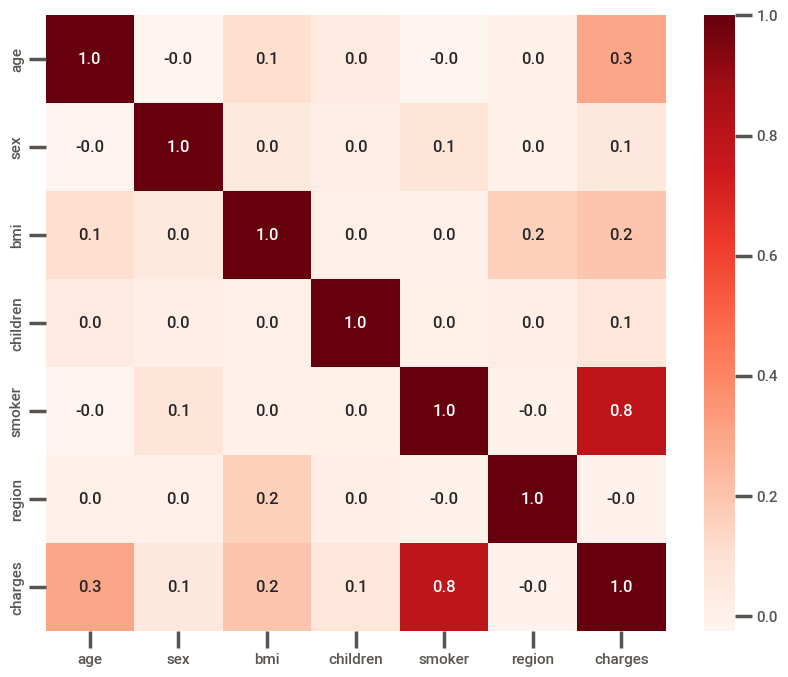

In [10]:
plt.figure(figsize=(10,8))
sns.set_context('poster',font_scale=0.5)
sns.heatmap(data.corr(),annot=True,fmt=".1f",cmap="Reds")

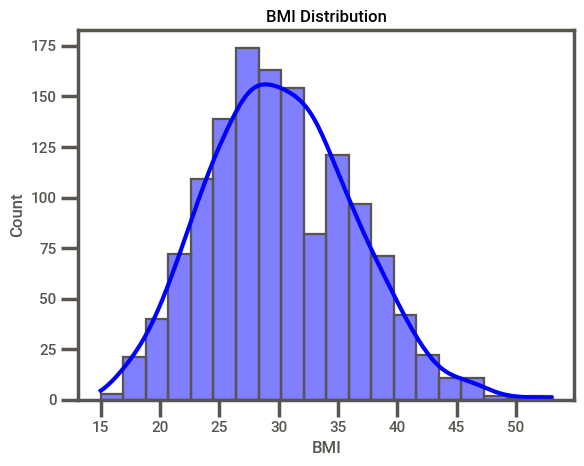

In [11]:
sns.histplot(data['bmi'],bins=20, kde=True,color='blue');plt.title('BMI Distribution');plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'SEX')

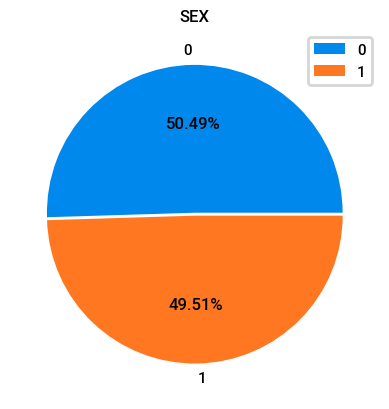

In [12]:
plt.pie(x = data['sex'].value_counts(), labels = data['sex'].unique(), autopct = '%1.2f%%',explode=[0.01,0.01])
plt.legend()
plt.title('SEX')

## Data Preprocessing 2

<Axes: >

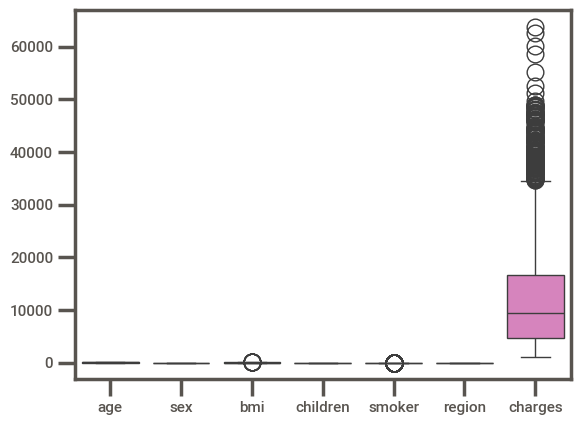

In [13]:
sns.boxplot(data)

In [14]:
If_model = IsolationForest(contamination=0.1) # outlier detection  and removing

If_model.fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1)

In [15]:
data['anomaly_scores'] = If_model.decision_function(data)
data.head()

data['anomaly'] = If_model.fit_predict(data) # anomaly < 0 = outlier or anomaly
data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,age,sex,bmi,children,smoker,region,charges,anomaly_scores,anomaly
0,19,0,27,0,1,3,16884.92400,-0.001787,1
1,18,1,33,1,0,2,1725.55230,0.100563,1
2,28,1,33,3,0,2,4449.46200,0.086683,1
3,33,1,22,0,0,1,21984.47061,0.065132,1
4,32,1,28,0,0,1,3866.85520,0.120113,1


In [16]:
data = data.query('anomaly_scores > 0 ')

In [17]:
data.shape

(1203, 9)

In [18]:
data.head()

,age,sex,bmi,children,smoker,region,charges,anomaly_scores,anomaly
1,18,1,33,1,0,2,1725.55230,0.100563,1
2,28,1,33,3,0,2,4449.46200,0.086683,1
3,33,1,22,0,0,1,21984.47061,0.065132,1
4,32,1,28,0,0,1,3866.85520,0.120113,1
5,31,0,25,0,0,2,3756.62160,0.129701,1


<Axes: >

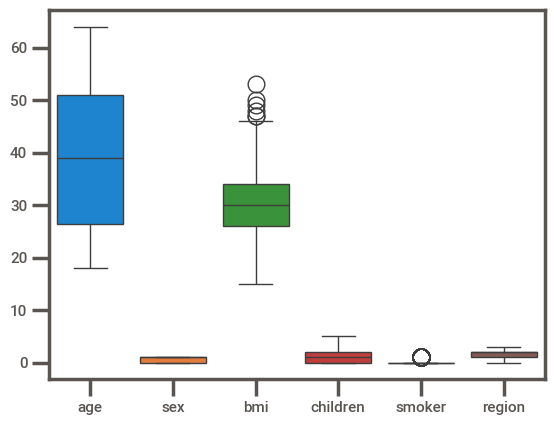

In [19]:
sns.boxplot(data.iloc[:,:-3])

In [20]:
selecteed_featurers =['bmi']
q1 = data[selecteed_featurers].quantile(0.25)
q3 = data[selecteed_featurers].quantile(0.75)
IQR = q3 - q1
th_1 = q1 - (1.5 * IQR)
th_2 = q3 + (1.5 * IQR)

In [21]:
data = data[~((data[selecteed_featurers] < (th_1)) |(data[selecteed_featurers] > (th_2))).any(axis=1)]
data.head()

,age,sex,bmi,children,smoker,region,charges,anomaly_scores,anomaly
1,18,1,33,1,0,2,1725.55230,0.100563,1
2,28,1,33,3,0,2,4449.46200,0.086683,1
3,33,1,22,0,0,1,21984.47061,0.065132,1
4,32,1,28,0,0,1,3866.85520,0.120113,1
5,31,0,25,0,0,2,3756.62160,0.129701,1


In [22]:
data = data.drop('anomaly_scores',axis=1)
data.drop('anomaly',axis=1,inplace=True)

In [23]:
data.head()

,age,sex,bmi,children,smoker,region,charges
1,18,1,33,1,0,2,1725.55230
2,28,1,33,3,0,2,4449.46200
3,33,1,22,0,0,1,21984.47061
4,32,1,28,0,0,1,3866.85520
5,31,0,25,0,0,2,3756.62160


<Axes: >

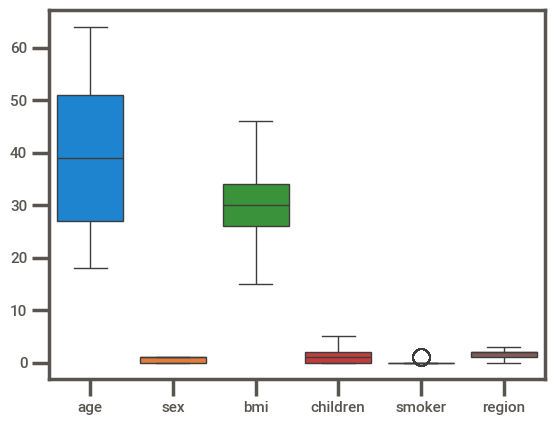

In [24]:
sns.boxplot(data.iloc[:,:-1])

## Model Building and evaluation

In [25]:
data.head()

,age,sex,bmi,children,smoker,region,charges
1,18,1,33,1,0,2,1725.55230
2,28,1,33,3,0,2,4449.46200
3,33,1,22,0,0,1,21984.47061
4,32,1,28,0,0,1,3866.85520
5,31,0,25,0,0,2,3756.62160


In [26]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

In [27]:
X_train ,X_test ,y_train ,y_test = train_test_split(X,Y,test_size=0.2)

In [28]:
#  ANN Model
ann_model = keras.Sequential([
  keras.layers.Dense(50, activation='relu'),
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(1)
])

In [29]:
ann_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

In [30]:
history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
24/24 [==============================] - 1s 12ms/step - loss: 204201056.0000 - mae: 10811.3672 - val_loss: 250499328.0000 - val_mae: 11750.4424
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 204028640.0000 - mae: 10803.9082 - val_loss: 250380848.0000 - val_mae: 11745.6533
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 203873760.0000 - mae: 10797.2266 - val_loss: 250165040.0000 - val_mae: 11736.9414
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 203594608.0000 - mae: 10785.2871 - val_loss: 249783760.0000 - val_mae: 11721.5029
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: 203113584.0000 - mae: 10764.3857 - val_loss: 249133952.0000 - val_mae: 11695.1250
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 202338160.0000 - mae: 10730.3604 - val_loss: 248117456.0000 - val_mae: 11653.6523
Epoch 7/20
24/24 [==============================] - 0s 4ms/step - loss: 201

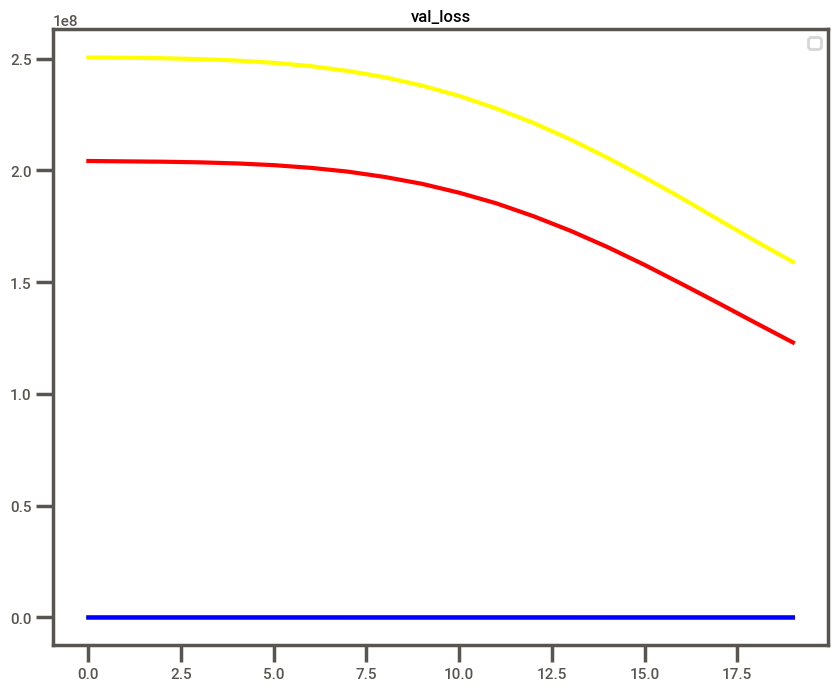

In [31]:
fig , ax = plt.subplots(figsize=(10,8))
ax.plot(history.history['mae'],color='green');plt.title('mae')
ax.plot(history.history['loss'],color='red');plt.title('loss')
ax.plot(history.history['val_mae'],color='blue');plt.title('val_mae')
ax.plot(history.history['val_loss'],color='yellow');plt.title('val_loss')
plt.legend()

In [32]:
y_pred_ann = ann_model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


<ipython-input-33-064e8e3f5d82>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_ann, color="y", label="ANN Prediction Value",hist=False)
<ipython-input-33-064e8e3f5d82>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,  color="g", label="Actual Value",hist=False)

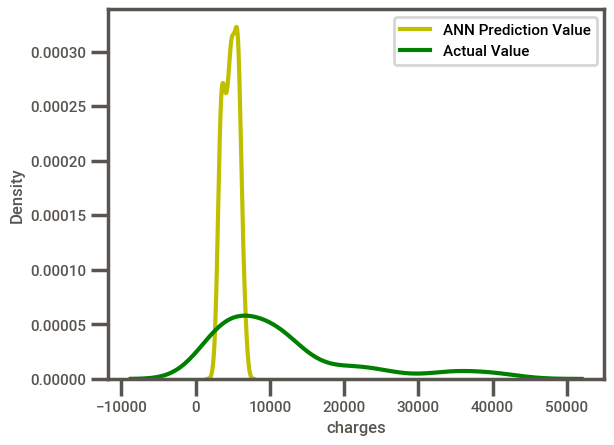

In [33]:
sns.distplot(y_pred_ann, color="y", label="ANN Prediction Value",hist=False)
sns.distplot(y_test,  color="g", label="Actual Value",hist=False)
plt.legend()

In [34]:
# Linear Regression
lr_model = LinearRegression()

In [35]:
lr_model.fit(X_train,y_train)

LinearRegression()

In [36]:
lr_score = lr_model.score(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)
print(lr_score)

0.6999874031003912


<ipython-input-37-8df79cd15759>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_lr, color="y", label="LinearRegression Prediction Value",hist=False)
<ipython-input-37-8df79cd15759>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,  color="g", label="Actual Value"

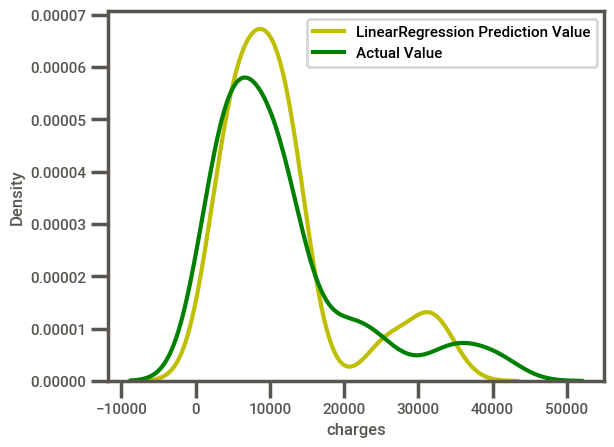

In [37]:
sns.distplot(y_pred_lr, color="y", label="LinearRegression Prediction Value",hist=False)
sns.distplot(y_test,  color="g", label="Actual Value",hist=False)
plt.legend()

In [38]:
MAE = mean_absolute_error(y_test, y_pred_lr)
MSE = np.sqrt(mean_squared_error(y_test, y_pred_lr))
R2_score =  r2_score(y_test, y_pred_lr)
print(MAE,'\n',MSE,'\n',R2_score)

3439.0597166455805 
 5593.633775727009 
 0.6762631701114736


In [39]:
## Ridge
alpha = 0.1
ridge_model = Ridge(alpha=alpha)

In [40]:
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [41]:
ridge_score = ridge_model.score(X_train,y_train)
y_pred_ridge = ridge_model.predict(X_test)
print(ridge_score)

0.6999868591899792


<ipython-input-42-eb10c49469fe>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_ridge, color="y", label="Ridge Prediction Value",hist=False)
<ipython-input-42-eb10c49469fe>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,  color="g", label="Actual Value",hist=Fa

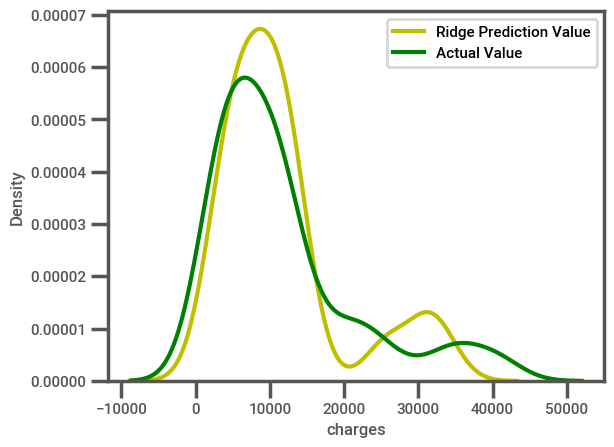

In [42]:
sns.distplot(y_pred_ridge, color="y", label="Ridge Prediction Value",hist=False)
sns.distplot(y_test,  color="g", label="Actual Value",hist=False)
plt.legend()

In [43]:
MAE_r = mean_absolute_error(y_test, y_pred_ridge)
MSE_r = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
R2_score_r =  r2_score(y_test, y_pred_ridge)
print(MAE_r,'\n',MSE_r,'\n',R2_score_r)

3440.2934309466796 
 5593.561947975809 
 0.6762714842557693


## by checking and evaluating the models on a data, we realize that it is better not to use neural network models for small data.